# EDA

In [1]:
import pandas as pd
import numpy as np
import os
import matplotlib.pyplot as plt
from skimage.io import imread
import random

In [2]:
folder_path = '/kaggle/input/airbus-ship-detection'
train_path = '/kaggle/input/airbus-ship-detection/train_v2'
test_path = '/kaggle/input/airbus-ship-detection/train_v2'

In [3]:
os.listdir(folder_path)

['test_v2',
 'sample_submission_v2.csv',
 'train_ship_segmentations_v2.csv',
 'train_v2']

In [4]:
train_files_list = os.listdir(os.path.join(folder_path, 'train_v2'))
print(f'Number of images in train set: {len(train_files_list)}')

test_files_list = os.listdir(os.path.join(folder_path, 'test_v2'))
print(f'Number of images in test set: {len(test_files_list)}')

Number of images in train set: 192556
Number of images in test set: 15606


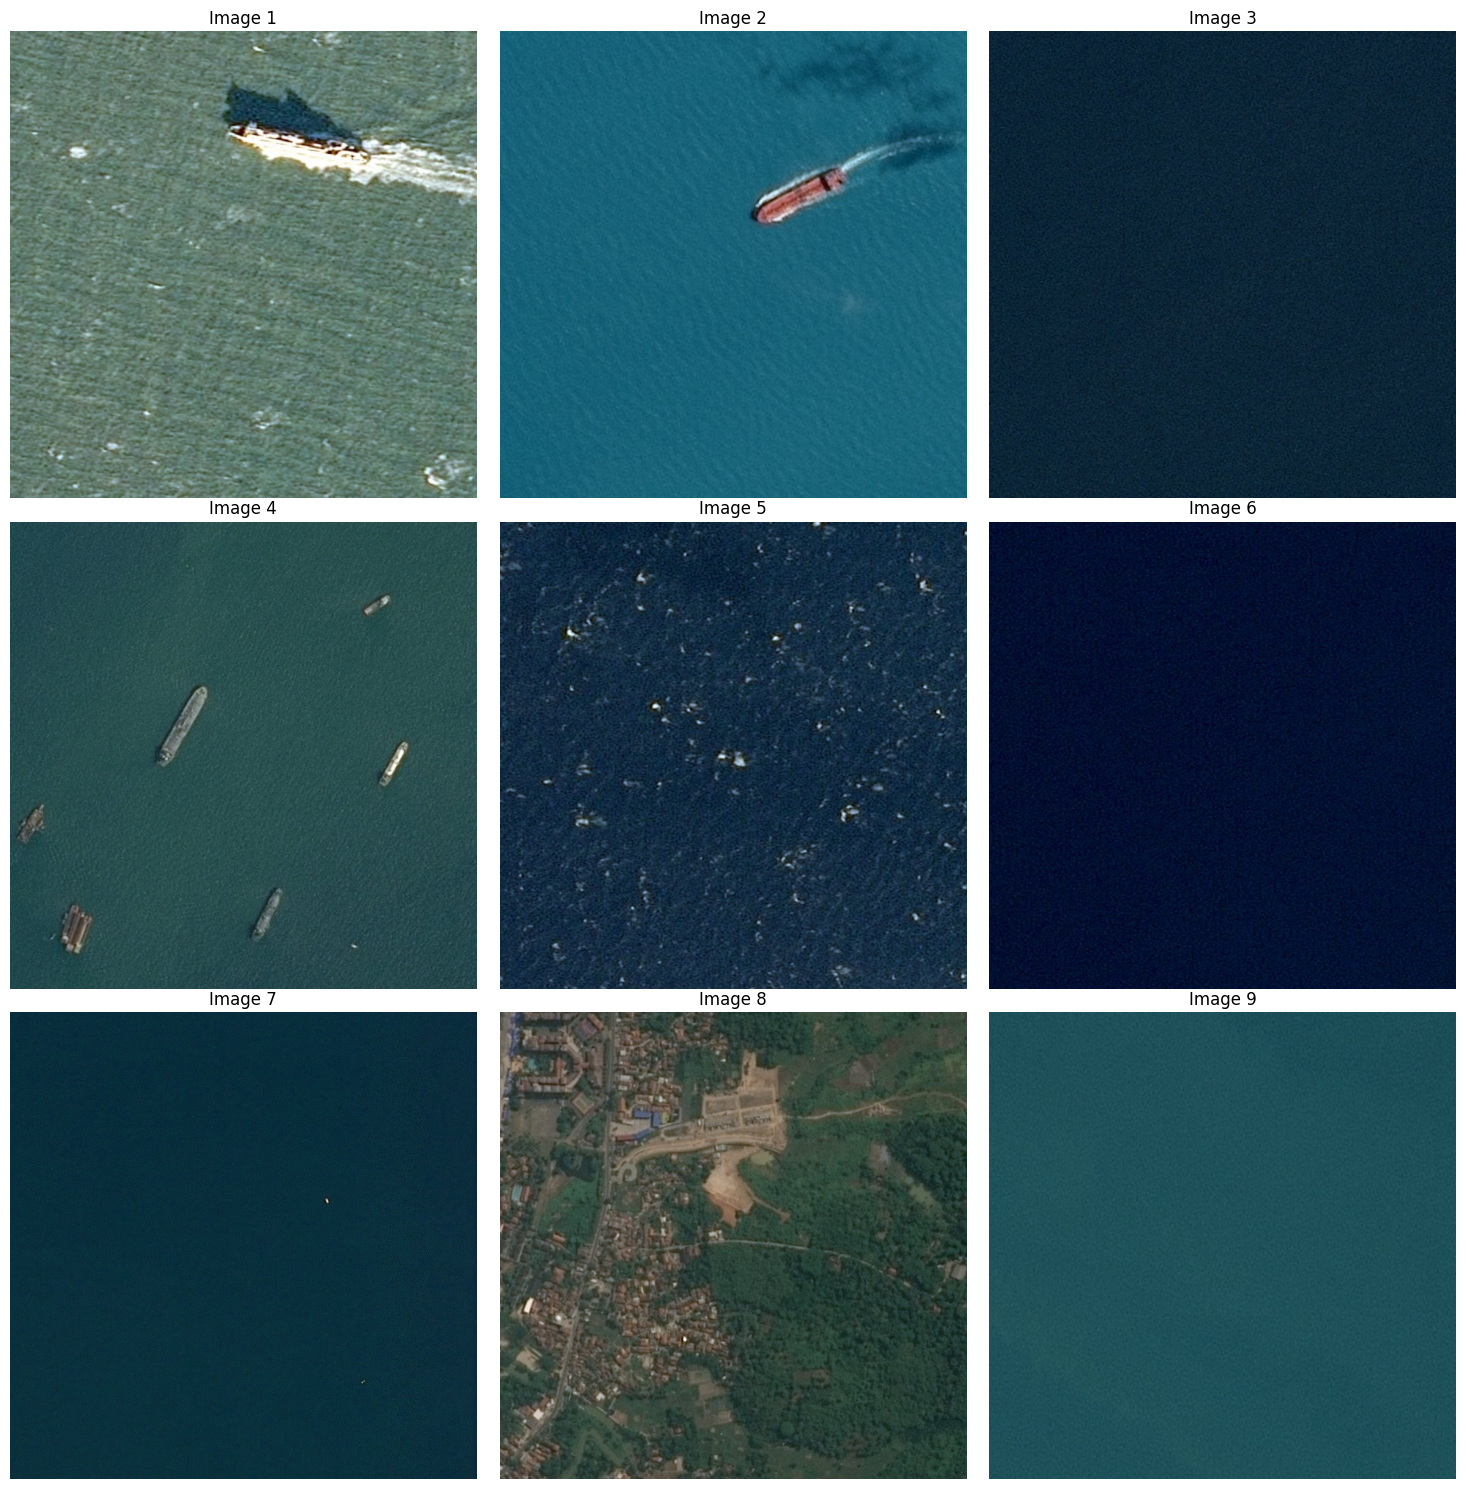

In [5]:
fig, axarr = plt.subplots(3, 3, figsize=(15, 15))

for i, ax in enumerate(axarr.flat):
    
    img = imread(os.path.join(train_path, train_files_list[i + 200]))
    ax.axis('off')
    ax.imshow(img)
    ax.set_title(f'Image {i+1}')

plt.tight_layout(h_pad=0.1, w_pad=0.1)
plt.show()

## Utility functions

In [6]:
# ref.: https://www.kaggle.com/stainsby/fast-tested-rle
def rle_encode(img):
    '''
    img: numpy array, 1 - mask, 0 - background
    Returns run length as string formated
    '''
    pixels = img.flatten()
    pixels = np.concatenate([[0], pixels, [0]])
    runs = np.where(pixels[1:] != pixels[:-1])[0] + 1
    runs[1::2] -= runs[::2]
    return ' '.join(str(x) for x in runs)
 
def rle_decode(mask_rle, shape=(768, 768)):
    '''
    mask_rle: run-length as string formated (start length)
    shape: (height,width) of array to return 
    Returns numpy array, 1 - mask, 0 - background

    '''
    s = mask_rle.split()
    starts, lengths = [np.asarray(x, dtype=int) for x in (s[0:][::2], s[1:][::2])]
    starts -= 1
    ends = starts + lengths
    img = np.zeros(shape[0]*shape[1], dtype=np.uint8)
    for lo, hi in zip(starts, ends):
        img[lo:hi] = 1
    return img.reshape(shape).T # added tranpose here

In [7]:
def masks_as_image(in_mask_list):
    # Take the individual ship masks and create a single mask array for all ships
    all_masks = np.zeros((768, 768), dtype = np.int16)
    #if isinstance(in_mask_list, list):
    for mask in in_mask_list:
        if isinstance(mask, str):
            all_masks += rle_decode(mask)
    return np.expand_dims(all_masks, -1)
  

## Masks

In [8]:
masks = pd.read_csv(os.path.join(folder_path,'train_ship_segmentations_v2.csv'))

print(masks.columns)
print(masks.shape[0], 'masks found')
print(masks['ImageId'].nunique(), 'images\n')

masks.head()

Index(['ImageId', 'EncodedPixels'], dtype='object')
231723 masks found
192556 images



ImageId                                      EncodedPixels
0  00003e153.jpg                                                NaN
1  0001124c7.jpg                                                NaN
2  000155de5.jpg  264661 17 265429 33 266197 33 266965 33 267733...
3  000194a2d.jpg  360486 1 361252 4 362019 5 362785 8 363552 10 ...
4  000194a2d.jpg  51834 9 52602 9 53370 9 54138 9 54906 9 55674 ...

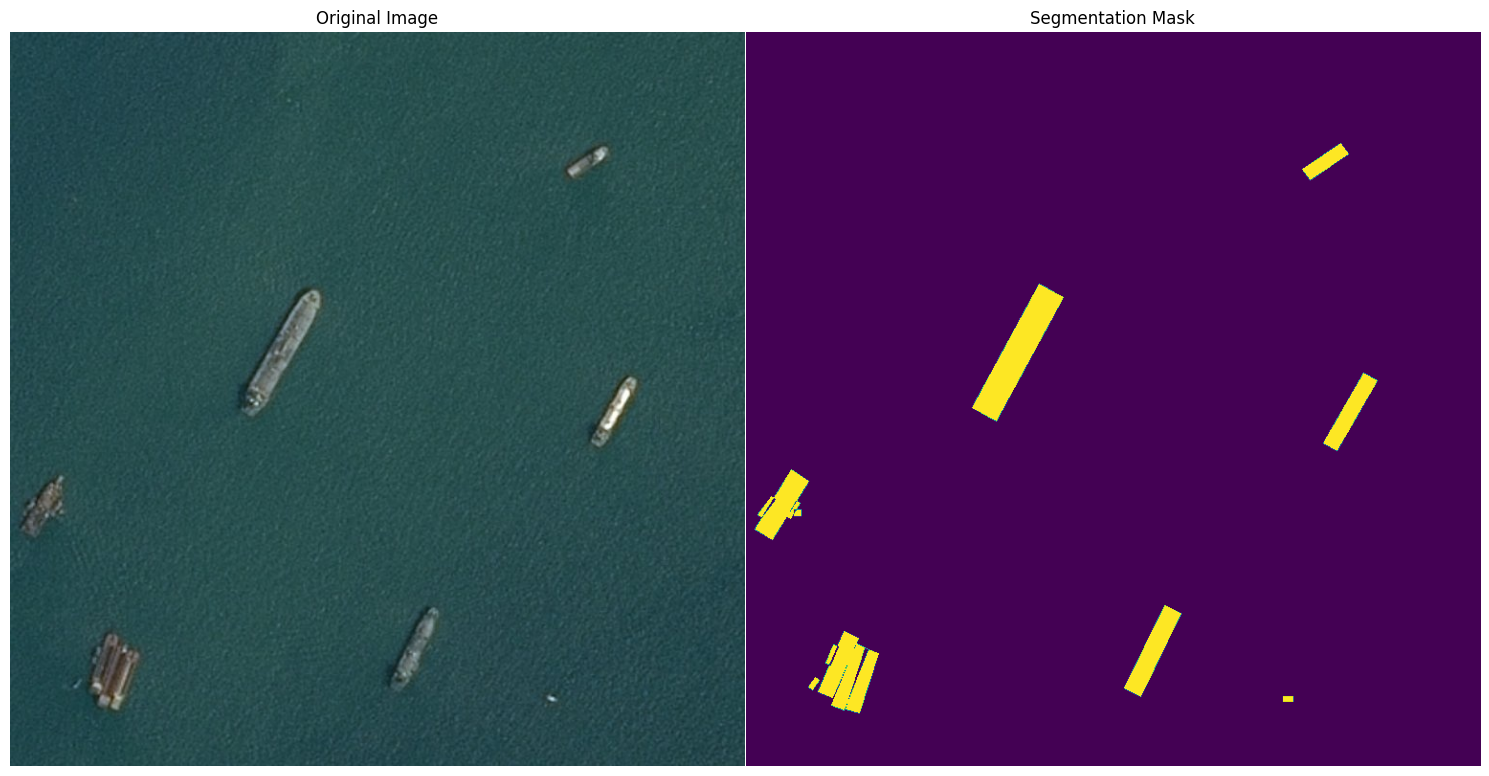

In [9]:
ImageId = train_files_list[203]

img = imread(os.path.join(train_path, ImageId))
img_masks = masks.loc[masks['ImageId'] == ImageId, 'EncodedPixels'].tolist()

all_masks = masks_as_image(img_masks)

fig, axarr = plt.subplots(1, 2, figsize=(15, 40))

axarr[0].axis('off')
axarr[1].axis('off')
# axarr[2].axis('off')

axarr[0].imshow(img)
axarr[1].imshow(all_masks)

axarr[0].set_title('Original Image')
axarr[1].set_title('Segmentation Mask')

plt.tight_layout(h_pad=0.1, w_pad=0.1)
plt.show()

## Examine Number of Ship Images

In [10]:
masks['NumOfShips'] = masks['EncodedPixels'].apply(lambda x: 1 if isinstance(x, str) else 0)

In [11]:
masks.head()

ImageId                                      EncodedPixels  \
0  00003e153.jpg                                                NaN   
1  0001124c7.jpg                                                NaN   
2  000155de5.jpg  264661 17 265429 33 266197 33 266965 33 267733...   
3  000194a2d.jpg  360486 1 361252 4 362019 5 362785 8 363552 10 ...   
4  000194a2d.jpg  51834 9 52602 9 53370 9 54138 9 54906 9 55674 ...   

   NumOfShips  
0           0  
1           0  
2           1  
3           1  
4           1

In [12]:
unique_img_ids = masks.groupby('ImageId').agg({'NumOfShips': 'sum'}).reset_index()
unique_img_ids['has_ship'] = unique_img_ids['NumOfShips'].map(lambda x: 1 if x > 0 else 0)
unique_img_ids = unique_img_ids[~unique_img_ids['ImageId'].isin(['6384c3e78.jpg'])] # remove corrupted file
masks.drop(['NumOfShips'], axis=1, inplace=True)
unique_img_ids

ImageId  NumOfShips  has_ship
0       00003e153.jpg           0         0
1       0001124c7.jpg           0         0
2       000155de5.jpg           1         1
3       000194a2d.jpg           5         1
4       0001b1832.jpg           0         0
...               ...         ...       ...
192551  fffedbb6b.jpg           0         0
192552  ffff2aa57.jpg           0         0
192553  ffff6e525.jpg           0         0
192554  ffffc50b4.jpg           0         0
192555  ffffe97f3.jpg           0         0

[192555 rows x 3 columns]

Number of images without ships: 149999
Number of images with ships: 42556

Number of images without ships (percents): 77.89930149827322%
Number of images with ships (percents): 22.100698501726782%


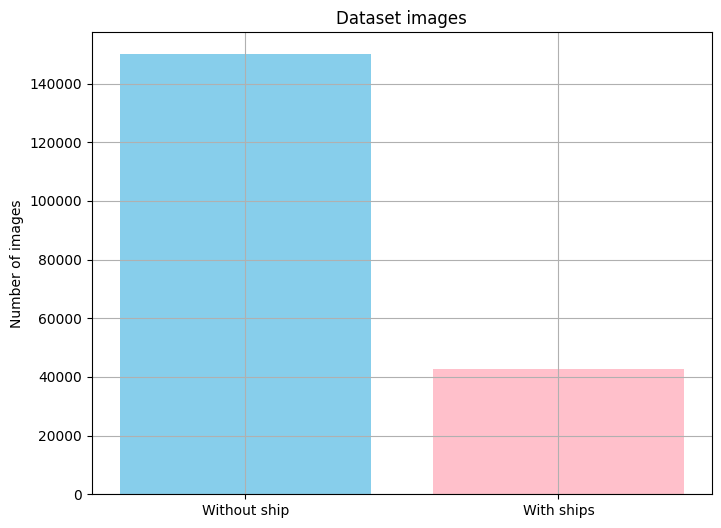

In [13]:
has_ship_counts = unique_img_ids['has_ship'].value_counts()

without_ships = has_ship_counts[0]
with_ships = has_ship_counts[1]


print(f'Number of images without ships: {without_ships}')
print(f'Number of images with ships: {with_ships}\n')

without_pct = (without_ships * 100) / (without_ships + with_ships)
with_pct = 100 - without_pct

print(f'Number of images without ships (percents): {without_pct}%')
print(f'Number of images with ships (percents): {with_pct}%')

plt.figure(figsize=(8, 6))

plt.bar(['Without ship','With ships'], has_ship_counts, color=['skyblue', 'pink'])
plt.title('Dataset images')

plt.ylabel('Number of images')

plt.grid()

plt.xticks(rotation=0)
plt.show()

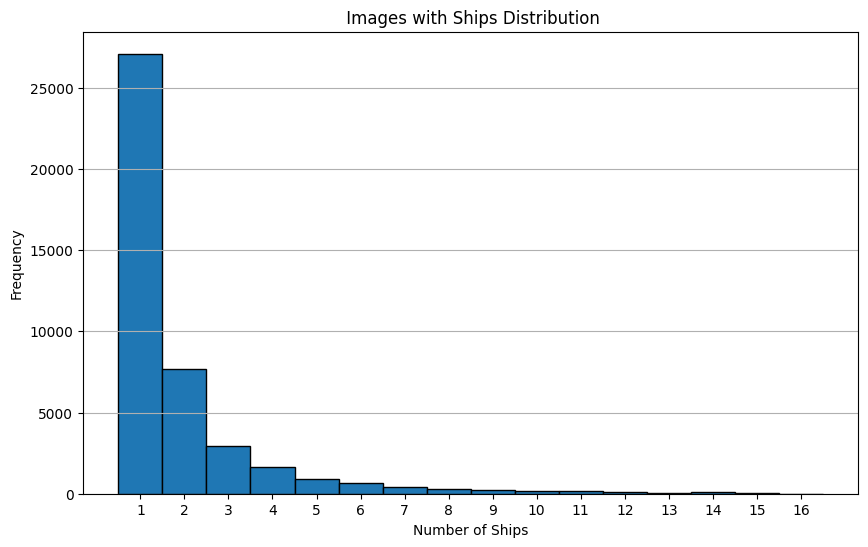

In [14]:
df_with_ships = unique_img_ids[unique_img_ids['has_ship'] == 1]

plt.figure(figsize=(10, 6))
plt.hist(df_with_ships['NumOfShips'], bins=range(1, 18), edgecolor='black', align='left')
plt.xticks(range(1, 17))
plt.xlabel('Number of Ships')
plt.ylabel('Frequency')
plt.title(' Images with Ships Distribution')
plt.grid(axis='y')

# Show the plot
plt.show()

## Split to train and validation set. Balance the sets

In [15]:
from sklearn.model_selection import train_test_split
train_ids, valid_ids = train_test_split(unique_img_ids, 
                 test_size = 0.3, 
                 stratify = unique_img_ids['NumOfShips'])
train_df = pd.merge(masks, train_ids)
valid_df = pd.merge(masks, valid_ids)
print(train_df.shape[0], 'training masks')
print(valid_df.shape[0], 'validation masks')

162200 training masks
69522 validation masks


<Axes: >

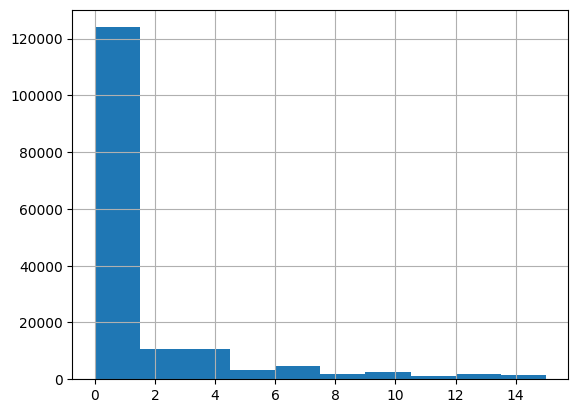

In [16]:
train_df['NumOfShips'].hist()

In [17]:
min_count = train_df['NumOfShips'].value_counts().min()
balanced_df = train_df.groupby('NumOfShips').apply(lambda x: x.sample(min_count)).reset_index(drop=True)
filtered_train_df = train_df[train_df['ImageId'].isin(balanced_df['ImageId'])]

/tmp/ipykernel_33/1635493319.py:2: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  balanced_df = train_df.groupby('NumOfShips').apply(lambda x: x.sample(min_count)).reset_index(drop=True)


<Axes: >

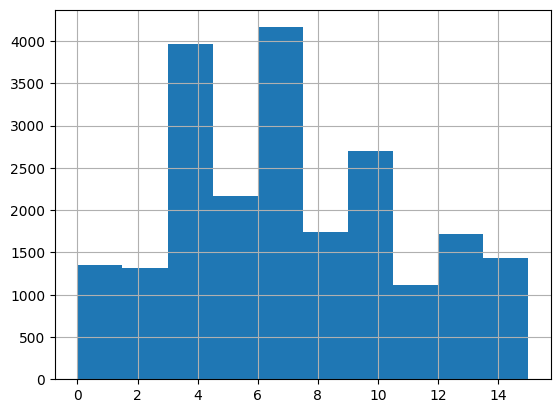

In [18]:
filtered_train_df['NumOfShips'].hist()

## Decode all RLE to Images


In [19]:
def df_rle_to_image(df, train_folder_path):
    img_ids = list(df.groupby('ImageId'))
    
    out_rgbs = []
    out_masks = []
    
    for img_info in img_ids:
        
        img_id = img_info[0]
        
        img_rgb = imread(os.path.join(train_folder_path, img_id))
        img_mask = masks_as_image(df.loc[df['ImageId'] == img_id, 'EncodedPixels'].tolist())
        
        out_rgbs += [img_rgb]
        out_masks += [img_mask]
        
    
    return out_rgbs, out_masks

 

In [20]:
x, y = df_rle_to_image(filtered_train_df, train_folder_path = train_path)

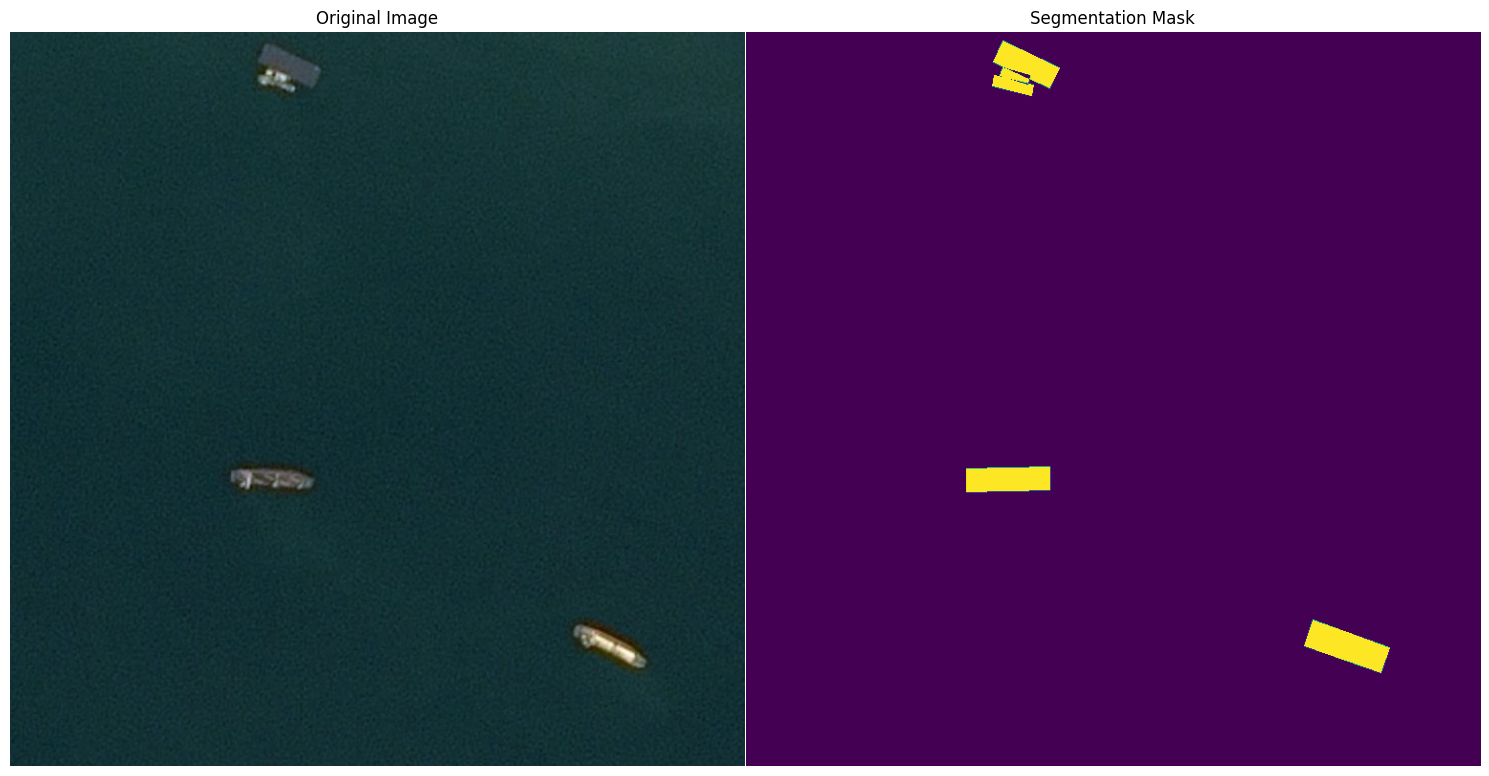

In [21]:
fig, axarr = plt.subplots(1, 2, figsize=(15, 40))

axarr[0].axis('off')
axarr[1].axis('off')
# axarr[2].axis('off')

axarr[0].imshow(x[1030])
axarr[1].imshow(y[1030])

axarr[0].set_title('Original Image')
axarr[1].set_title('Segmentation Mask')

plt.tight_layout(h_pad=0.1, w_pad=0.1)
plt.show()

In [22]:
def batch_gen(batch_size, images, masks):
    
    out_rgb = []
    out_mask = []
    
    while True:
        # random shuffle
        combined = list(zip(images, masks))
        random.shuffle(combined)


        for image, mask in combined:

            out_rgb.append(image)
            out_mask.append(mask)

            if len(out_rgb)>=batch_size:
                yield np.stack(out_rgb, 0)/255.0, np.stack(out_mask, 0)
                out_rgb, out_mask=[], []

    

In [23]:
b_gen = batch_gen(4, x, y)

In [24]:
batch_x, batch_y = next(b_gen)

In [25]:
batch_y.shape

(4, 768, 768, 1)

## Augment data

In [26]:
# x = np.asarray(x)
# y = np.asarray(y)

In [27]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator


datagen_args = dict(
    rotation_range=90,  # randomly rotate images by up to 90 degrees
    width_shift_range=0.1,  # randomly shift images horizontally by up to 10%
    height_shift_range=0.1,  # randomly shift images vertically by up to 10%
    shear_range=0.02,  # shear angle in counter-clockwise direction in degrees
    zoom_range=0.2,  # randomly zoom into images by up to 20%
    horizontal_flip=True,  # randomly flip images horizontally
    vertical_flip=True,  # randomly flip images vertically
    fill_mode='reflect')
    
image_gen = ImageDataGenerator(**datagen_args)
mask_gen = ImageDataGenerator(**datagen_args)



2024-07-14 19:18:56.163993: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-07-14 19:18:56.164130: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-07-14 19:18:56.314986: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


In [28]:
def augment_generator(batch_gen, seed = 67):
    np.random.seed(seed)
    
    for x, y in batch_gen:
        
#         seed = np.random.choice(range(9999))
        batch_size = x.shape[0]
        g_x = image_gen.flow(255*x, batch_size = batch_size, seed = seed)
        g_y = mask_gen.flow(y, batch_size = batch_size, seed = seed)
        

        yield next(g_x)/255.0, next(g_y)
        

In [29]:
augm_gen = augment_generator(b_gen)

augm_x, augm_y = next(augm_gen)

print('x', augm_x.shape, augm_x.dtype, augm_x.min(), augm_x.max())
print('y', augm_y.shape, augm_y.dtype, augm_y.min(), augm_y.max())



x (4, 768, 768, 3) float32 0.0 0.9997459
y (4, 768, 768, 1) float32 0.0 1.0


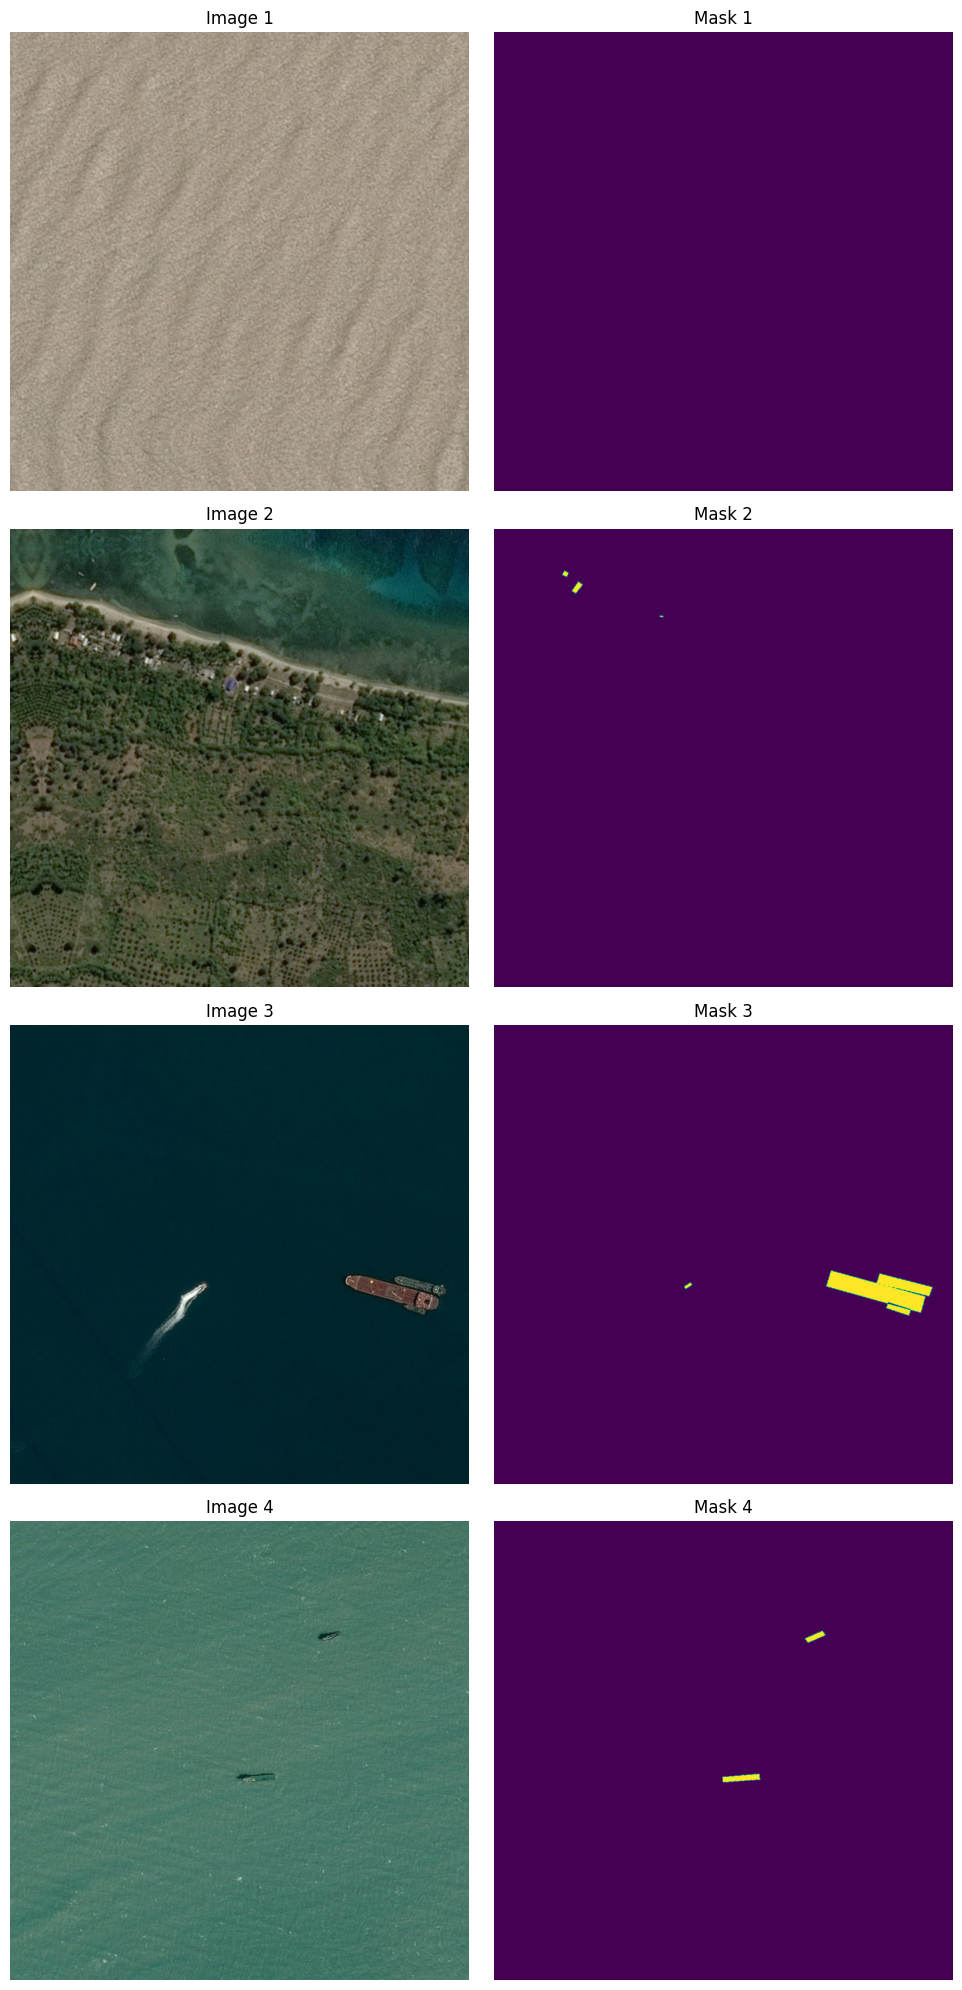

In [30]:
augm_x = augm_x[:4]
augm_y = augm_y[:4]

# Displaying the images and their corresponding masks
fig, axs = plt.subplots(4, 2, figsize=(10, 20))
for i in range(4):
    axs[i, 0].imshow(augm_x[i])
    axs[i, 0].set_title(f'Image {i+1}')
    axs[i, 0].axis('off')
    axs[i, 1].imshow(augm_y[i, :, :, 0])
    axs[i, 1].set_title(f'Mask {i+1}')
    axs[i, 1].axis('off')
plt.tight_layout()
plt.show()

In [31]:
def montage_images(images, ncols=5):
    
    nindex, height, width, intensity = images.shape
    nrows = int(np.ceil(nindex / ncols))
    
    # Pad with empty images if necessary
    padded_images = np.zeros((nrows * ncols, height, width, intensity), dtype=images.dtype)
    padded_images[:nindex, :, :, :] = images
    
    # Create the montage
    montage_image = (padded_images.reshape(nrows, ncols, height, width, intensity)
                                   .swapaxes(1, 2)
                                   .reshape(height * nrows, width * ncols, intensity))
    return montage_image

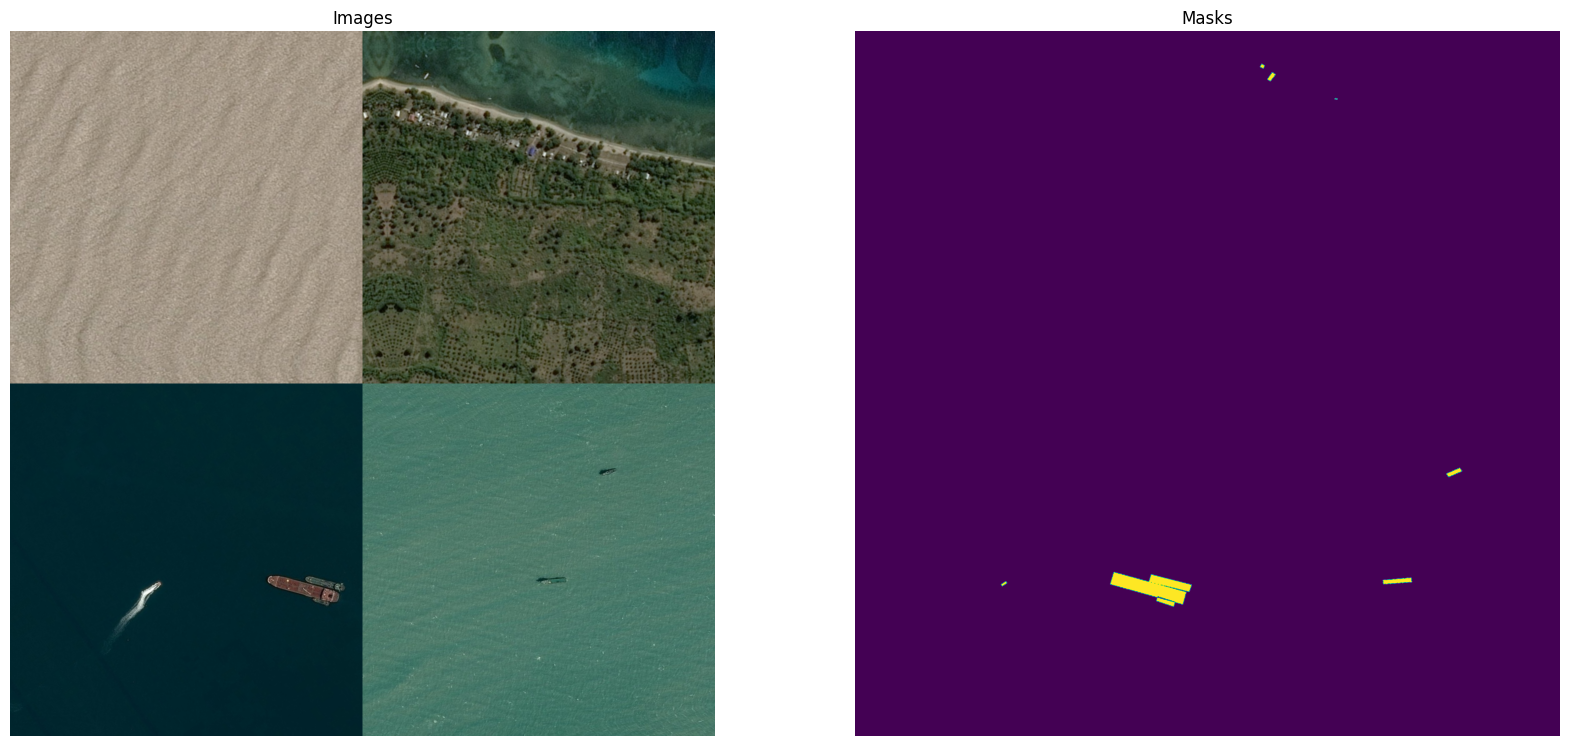

In [32]:
augm_x = augm_x[:4]
augm_y = augm_y[:4]

# Displaying the images and their corresponding masks using montage
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(20, 10))

# Display the montage of the images
ax1.imshow(montage_images(augm_x, ncols=2))
ax1.set_title('Images')
ax1.axis('off')

# Display the montage of the masks
ax2.imshow(montage_images(augm_y[:, :, :, 0].reshape(augm_y.shape[0], augm_y.shape[1], augm_y.shape[2], 1), ncols=2))
ax2.set_title('Masks')
ax2.axis('off')

plt.show()